In [1]:
import time
import pickle
import numpy as np
import pandas as pd
import networkx as nx

# Чтение графа

In [113]:
graph = nx.read_graphml('so_graph.graphml')

print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 684
Number of edges: 27052


# Центральности

In [114]:
degree_centrality = nx.degree_centrality(graph)
betweenness_centrality = nx.betweenness_centrality(graph)
closeness_centrality = nx.closeness_centrality(graph)
eigenvector_centrality = nx.eigenvector_centrality(graph)

In [115]:
centr_embs = {}
for node in graph.nodes():
    centr_embs[node] = np.array([
        degree_centrality[node],
        betweenness_centrality[node],
        closeness_centrality[node],
        eigenvector_centrality[node]
    ])

In [117]:
with open('centrality_embs.pkl', 'wb') as file:
    pickle.dump(centr_embs, file)

# SVD

In [164]:
from scipy.sparse.linalg import svds

In [165]:
# матрица смежности
adj_matrix = nx.adjacency_matrix(graph).astype(float)
U, s, _ = svds(adj_matrix, k=64)
svd_adj_embs = {node: U[i] for i, node in enumerate(graph.nodes)}

In [166]:
with open('svd_adj_embs.pkl', 'wb') as file:
    pickle.dump(svd_adj_embs, file)

In [167]:
# лаплассиан
norm_laplacian_matrix = nx.linalg.normalized_laplacian_matrix(graph)
U, s, _ = svds(adj_matrix, k=64)
svd_lapl_embs = {node: U[i] for i, node in enumerate(graph.nodes)}

In [168]:
with open('svd_lapl_embs.pkl', 'wb') as file:
    pickle.dump(svd_lapl_embs, file)

# GCN + Autoencoders

In [124]:
import torch 
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, GAE, VGAE

In [125]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [126]:
# Сопоставляем тегам индексы
tag_to_idx = {tag: i for i, tag in enumerate(graph.nodes())}

# Матрица рёбер (2, num_edges) и весов
edge_index = []
edge_weight = []
for (tag1, tag2, data) in graph.edges(data=True):
    edge_index.append([tag_to_idx[tag1], tag_to_idx[tag2]])
    edge_weight.append(data['weight'])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Признаки узлов (если нет атрибутов — используем one-hot)
x = torch.eye(len(tag_to_idx))  # One-hot

data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

In [127]:
def train(data, model, optimizer, variational=False):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    if variational:
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [128]:
encoder = GCNEncoder(in_channels=data.num_features, out_channels=64)
gae = GAE(encoder=encoder)
gae = gae.to(device)

optimizer = torch.optim.Adam(gae.parameters(), lr=0.01)

epochs = 200
gae_losses = []
for epoch in range(1, epochs + 1):
    loss = train(data, gae, optimizer)
    gae_losses.append(loss)

In [129]:
encoder = VariationalGCNEncoder(in_channels=data.num_features, out_channels=64)
vgae = VGAE(encoder=encoder)
vgae = vgae.to(device)

optimizer = torch.optim.Adam(vgae.parameters(), lr=0.01)

epochs = 200
vgae_losses = []
for epoch in range(1, epochs + 1):
    loss = train(data, vgae, optimizer, variational=True)
    vgae_losses.append(loss)

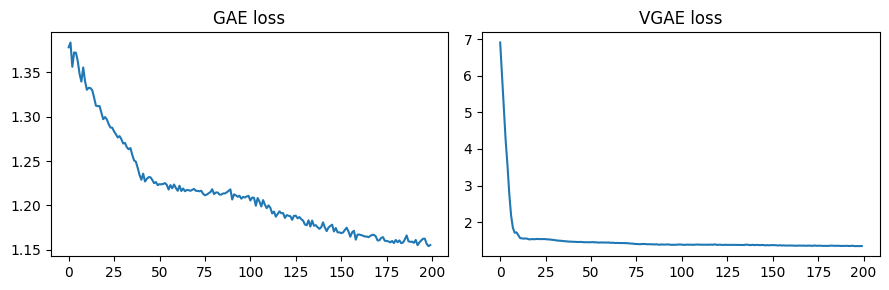

In [130]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(9,3))
axes[0].plot(gae_losses)
axes[0].set_title('GAE loss')
axes[1].plot(vgae_losses)
axes[1].set_title('VGAE loss')
plt.tight_layout()

In [134]:
gae.eval()
with torch.no_grad():
    gae_embeddings = gae(data.x, data.edge_index).numpy()  # (n_tags, 64)

gae_embeddings_dict = {}
for tag, idx in tag_to_idx.items():
    gae_embeddings_dict[tag] = gae_embeddings[idx]

with open('gae_gcn_embds.pkl', 'wb') as file:
    pickle.dump(gae_embeddings_dict, file)

In [162]:
vgae.eval()
with torch.no_grad():
    vgae_embeddings = torch.cat(vgae(data.x, data.edge_index), dim=1).numpy()  # (n_tags, 64)

vgae_embeddings_dict = {}
for tag, idx in tag_to_idx.items():
    vgae_embeddings_dict[tag] = vgae_embeddings[idx]

with open('vgae_gcn_embds.pkl', 'wb') as file:
    pickle.dump(vgae_embeddings_dict, file)

# GAT + GAE

In [197]:
from torch.nn import Dropout

class WeightedGAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim, heads=2):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, edge_dim=1)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, edge_dim=1)
        self.dropout = Dropout(0.2)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr=edge_attr).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        return x

In [198]:
encoder = WeightedGAT(num_features=len(tag_to_idx), hidden_dim=128, output_dim=64)
model = GAE(encoder=encoder)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [199]:
epochs = 200
gae_losses = []
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data)
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()
    gae_losses.append(float(loss))

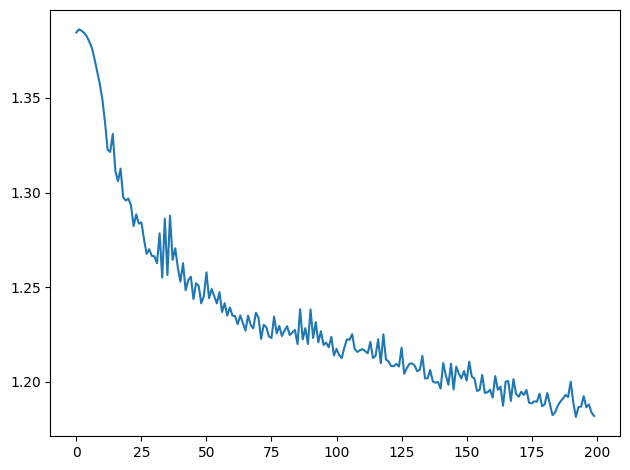

In [200]:
plt.plot(gae_losses)
plt.tight_layout()

In [201]:
model.eval()
with torch.no_grad():
    gae_embeddings = model(data).numpy()  # (n_tags, 64)

gae_embeddings_dict = {}
for tag, idx in tag_to_idx.items():
    gae_embeddings_dict[tag] = gae_embeddings[idx]

with open('gae_gat_embds.pkl', 'wb') as file:
    pickle.dump(gae_embeddings_dict, file)